<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Test_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Codes for MGTF 405

## Test Code for Assignment 2

We will use the Goyal Welch dataset obtained from the following page:
https://drive.google.com/file/d/1ACbhdnIy0VbCWgsnXkjcddiV8HF4feWv/view?usp=sharing

We will be testing the following procedures:
* ARIMA, and Lag Selection
* ADF tests
* ACF, PACF, Ljung Box Test
* Lasso, Elastic Net

In [1]:
import pandas as pd

In [11]:
df = pd.read_excel('/content/drive/MyDrive/PredictorData2020.xlsx', parse_dates=True)

In [13]:
df['yyyymm'] = pd.to_datetime(df['yyyymm'])

In [14]:
df.set_index('yyyymm',inplace=True)
df.head()


,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
yyyymm,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000192701,13.21,0.6967,1.229,0.443706,0.0323,0.0466,0.0561,0.0351,0.050824,0.0025,-0.011299,0.0075,0.0056,0.000470,NaN,-0.002910,-0.005579
1970-01-01 00:00:00.000192702,13.84,0.7033,1.218,0.428501,0.0329,0.0467,0.0559,0.0347,0.051668,0.0026,-0.005714,0.0088,0.0069,0.000287,NaN,0.045522,0.040566
1970-01-01 00:00:00.000192703,13.93,0.7100,1.208,0.469765,0.0320,0.0462,0.0554,0.0331,0.046357,0.0030,-0.005747,0.0253,0.0083,0.000924,NaN,0.007324,0.002610
1970-01-01 00:00:00.000192704,14.17,0.7167,1.197,0.456754,0.0339,0.0458,0.0548,0.0333,0.050514,0.0025,0.000000,-0.0005,0.0055,0.000603,NaN,0.013021,0.010907
1970-01-01 00:00:00.000192705,14.91,0.7233,1.186,0.434783,0.0333,0.0457,0.0550,0.0327,0.055275,0.0030,0.005780,0.0109,-0.0011,0.000392,NaN,0.062353,0.057096


In [15]:
! pip install statsmodels -U

     |████████████████████████████████| 9.8 MB 15.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [16]:
!pip install pmdarima
import pmdarima
import itertools
from statsmodels.tsa.arima.model import ARIMA

     |████████████████████████████████| 1.4 MB 14.2 MB/s 


The function

```
AIC_PDQ
```

takes 4 arguments, the series, max lag on the AR parameters labeled 'p', the integration order labeled 'ii', and the max lags on the MA parameter labeled 'q'. If we know the series does not need to be differenced, then we set ii=1, if the integration order is 1, then we set ii=2.

The output of the function is the combination of p,d,q that minimizes AIC,

We create a similar function called:
```
BIC_PDQ
```
which takes the same arguments, however, returns the combination of p,d,q that minimizes BIC.


In [22]:
def AIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any value between 0 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'aic'])
    print(ans_df.loc[ans_df['aic'].idxmin()])
    return ans_df


In [ ]:
AIC_PDQ(df['Index'],12,1,12)

In [24]:
def BIC_PDQ(df,ar,ii,ma): 

# Define the p, d and q parameters to take any value between 0 and 2
    p = range(0,ar)
    d = range(0,ii)
    q = range(0, ma)

# Auto-Regressive (p) -> Number of autoregressive terms.
# Integrated (d) -> Number of nonseasonal differences needed for stationarity.
# Moving Average (q) -> Number of lagged forecast errors in the prediction equation.
# Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
# Run a grid with pdq and seasonal pdq parameters calculated above and get #the best AIC value
    ans = []
    for comb in pdq:
      try:
          mod = ARIMA(df,
                      order=comb,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
          
          output = mod.fit()
          ans.append([comb, output.aic])
          print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.bic))
      except:
        continue
# Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'bic'])
    print(ans_df.loc[ans_df['bic'].idxmin()])
    return ans_df


In [ ]:
BIC_PDQ(df['Index'],12,1,12)

We will now shift gears and focus on the Autocorrelation (ACF) and Partial Autocorrelation functions (PACF).

In [28]:
import statsmodels.api as sm

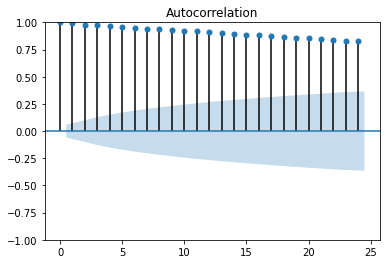

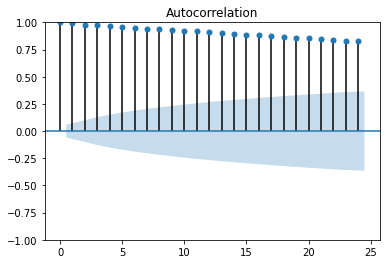

In [30]:
sm.graphics.tsa.plot_acf(df['Index'].squeeze(), lags=24)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


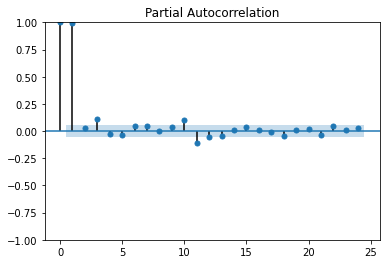

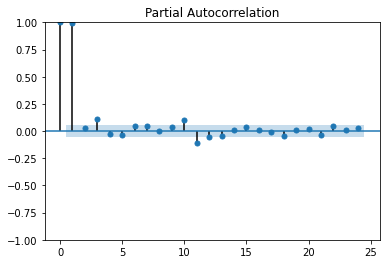

In [31]:
sm.graphics.tsa.plot_pacf(df['Index'].squeeze(), lags=24)

In [ ]:
res = ARIMA(df['Index'],order=(10,0,11)).fit()

In [34]:
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Index   No. Observations:                 1128
Model:               ARIMA(10, 0, 11)   Log Likelihood               -5647.406
Date:                Wed, 29 Dec 2021   AIC                          11340.812
Time:                        07:07:11   BIC                          11456.461
Sample:                             0   HQIC                         11384.509
                               - 1128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        486.8684      0.001   3.48e+05      0.000     486.866     486.871
ar.L1          0.1237      0.052      2.401      0.016       0.023       0.225
ar.L2          0.3177      0.042      7.607      0.000       0.236       0.400
ar.L3         -0.6905      0.059    -11.626      0.000      -0.807      -0.574
ar.L4         -0.1282      0.051     -2.539      0.011      -0.227      -0.029
ar.L5          0.0099      0.044      0.223      0.823      -0.077       0.096
ar.L6          0.0891      0.054      1.645      0.100      -0.017       0.195
ar.L7          0.7965      0.044     18.232      0.000       0.711       0.882
ar.L8         -0.1699      0.061     -2.764      0.006      -0.290      -0.049
ar.L9         -0.1010      0.040     -2.501      0.012      -0.180      -0.022
ar.L10         0.7523      0.046     16.313      0.000       0.662       0.843
ma.L1          0.9439      0.057     16.456      0.000       0.831       1.056
ma.L2          0.4803      0.075      6.371      0.000       0.333       0.628
ma.L3          1.2464      0.066     18.874      0.000       1.117       1.376
ma.L4          1.4771      0.050     29.491      0.000       1.379       1.575
ma.L5          1.3923      0.070     20.007      0.000       1.256       1.529
ma.L6          1.2583      0.083     15.241      0.000       1.097       1.420
ma.L7          0.6076      0.076      7.954      0.000       0.458       0.757
ma.L8          0.7715      0.053     14.486      0.000       0.667       0.876
ma.L9          0.8118      0.034     23.910      0.000       0.745       0.878
ma.L10         0.1264      0.033      3.814      0.000       0.061       0.191
ma.L11         0.1089      0.023      4.669      0.000       0.063       0.155
sigma2      1343.4589     25.254     53.198      0.000    1293.962    1392.956
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15494.90
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):            2633.28   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.07e+20. Standard errors may be unstable.
"""

In [37]:
sm.stats.acorr_ljungbox(res.resid, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,9.617836,0.649448


In [38]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [39]:
adf_test(df['Index'])

Results of Dickey-Fuller Test:
Test Statistic                    4.364641
p-value                           1.000000
#Lags Used                       22.000000
Number of Observations Used    1105.000000
Critical Value (1%)              -3.436282
Critical Value (5%)              -2.864159
Critical Value (10%)             -2.568165
dtype: float64
